In [32]:
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Flatten, Dropout, Dense, Reshape, Activation, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from numpy.random import randint, randn
from keras import backend as K


In [3]:
# function to load and process the MNIST data
def load_mnist(subst):
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
    # Normalize pixel values to be between 0 and 1
    x_train, x_test= x_train / 255.0, x_test/225.0
    if subst =="train":
      return x_train, y_train
    if subst=="test":
      return x_test, y_test



In [4]:
dataset = load_mnist("train")
print(dataset[0].shape)
print(dataset[1].shape)


11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(60000,)


In [5]:

def creating_labeled_image(dataset, num_labeled_images=100,num_classes=10):
  X,y = dataset[0], dataset[1]
  x_labeled, y_labeled = list(), list()
  im_per_class = 10
  for i in range(num_classes):
    X_class = X[y==i]
    ix = randint(0,len(X_class),im_per_class)
    for j in ix:
      x_labeled.append(X_class[j])
      y_labeled.append(i)
  return np.array(x_labeled), np.array(y_labeled)



In [6]:
#so by creating this function we only choose 100 images to label
X,Y = creating_labeled_image(dataset)
print(X.shape)
print(Y)

(100, 28, 28, 1)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 7 7 7 7
 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9]


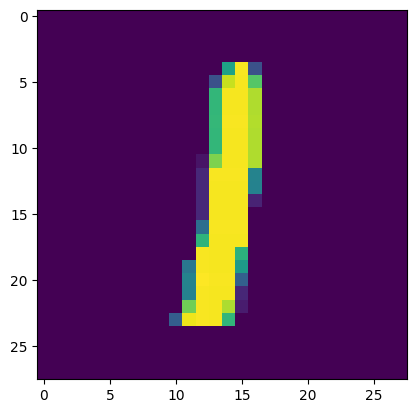

In [7]:
# plot of an image from the 100 labeled images
#plt.imshow(X[3]) ### the image is 0 because we classified our labeled images as so
plt.imshow(X[13]) # the image is 1 because of the function we created

In [8]:
dim_z = 100
batch_size = 100

In [9]:
#defining the generator
def define_generator(latent_dim):

    in_lat = Input(shape=(latent_dim,))
    n_nodes = 256 * 7 * 7
    X = Dense(n_nodes)(in_lat)
    X = LeakyReLU(alpha=0.2)(X)
    X = Reshape((7, 7, 256))(X)

    X = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(X)  # 14x14x128
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(X)  # 14x14x64
    X = LeakyReLU(alpha=0.2)(X)

    # Output layer
    out_layer = Conv2DTranspose(1, (3, 3), strides=(2, 2), activation='sigmoid', padding='same')(X)  # 28x28x1

    # Define model
    model = Model(in_lat, out_layer)
    return model

In [10]:
gen_model=define_generator(100)
print(gen_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       295040    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                             

In [11]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):
    in_image = Input(shape=in_shape)
    X = Conv2D(32, (3,3), strides=(2,2), padding='same')(in_image)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(64, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Conv2D(128, (3,3), strides=(2,2), padding='same')(X)
    X = LeakyReLU(alpha=0.2)(X)

    X = Flatten()(X)
    X = Dropout(0.4)(X) #Consider adding more dropout layers to minimize overfitting - remember we work with limited labeled data.
    X = Dense(n_classes)(X)

    model = Model(inputs=in_image, outputs=X)

    return model

In [12]:
def define_sup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Activation('softmax'))
    #Let us use sparse categorical loss so we dont have to convert our Y to categorical
    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5),
                  loss="sparse_categorical_crossentropy",metrics=['accuracy'])
    return model

In [13]:
def activation(x):
    Z_x = K.sum(K.exp(x), axis=-1, keepdims=True)
    D_x = Z_x /(Z_x+1)

    return D_x


In [14]:
def define_unsup_discriminator(disc):
    model=Sequential()
    model.add(disc)
    model.add(Lambda(activation))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

In [15]:
disc=define_discriminator()
disc_sup=define_sup_discriminator(disc)
disc_unsup=define_unsup_discriminator(disc)
print(disc_unsup.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_1 (Functional)        (None, 10)                113162    
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 113162 (442.04 KB)
Trainable params: 113162 (442.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
def define_gan(gen_model, disc_unsup):

	disc_unsup.trainable = False # make unsup. discriminator not trainable
	gan_output = disc_unsup(gen_model.output) #Gen. output is the input to disc.
	model = Model(gen_model.input, gan_output)
	model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
	return model

In [18]:
gan_model = define_gan(gen_model, disc_unsup)
print(gan_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       295040    
 anspose)                                                        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                           

In [28]:
def generate_real_samples(dataset, n_samples):

	images, labels = dataset
	ix = randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix] #Select random images and corresponding labels
	y = np.ones((n_samples, 1)) #Label all images as 1 as these are real images. (for the discriminator training)
	return [X, labels], y

In [29]:
def generate_latent_points(latent_dim, n_samples):
	z_input = randn(latent_dim * n_samples)
	z_input = z_input.reshape(n_samples, latent_dim) # reshape for input to the network
	return z_input

In [30]:
def generate_fake_samples(generator, latent_dim, n_samples):

	z_input = generate_latent_points(latent_dim, n_samples)
	fake_images = generator.predict(z_input)
	# create class labels
	y = np.zeros((n_samples, 1)) #Label all images as 0 as these are fake images. (for the discriminator training)
	return fake_images, y

In [22]:
def summarize_performance(step, gen_model, disc_sup, latent_dim, dataset, n_samples=100):
	# Generate fake images
	X, _ = generate_fake_samples(gen_model, latent_dim, n_samples)

	X = (X + 1) / 2.0 # scale to [0,1] for plotting
	# plot images
	for i in range(100):
		plt.subplot(10, 10, 1 + i)
		plt.axis('off')
		plt.imshow(X[i, :, :, 0], cmap='gray_r')
	# save plot to drive
	filename1 = 'generated_plot_%04d.png' % (step+1)
	plt.savefig(filename1)
	plt.close()

	# evaluate the discriminator
	X, y = dataset
	_, acc = disc_sup.evaluate(X, y, verbose=0)
	print('Discriminator Accuracy: %.3f%%' % (acc * 100))
	# save the generator model
	filename2 = 'gen_model_%04d.h5' % (step+1)
	gen_model.save(filename2)
	# save the Discriminator (classifier) model
	filename3 = 'disc_sup_%04d.h5' % (step+1)
	disc_sup.save(filename3)
	print('>Saved: %s, %s, and %s' % (filename1, filename2, filename3))


In [34]:
def train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=20, n_batch=100):

    # select supervised dataset for training.
    #Remember that we are not using all 60k images, just a subset (100 images, 10 per class. )
	X_sup, y_sup = creating_labeled_image(dataset)
	#print(X_sup.shape, y_sup.shape)

	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	# iterations
	n_steps = bat_per_epo * n_epochs

	half_batch = int(n_batch / 2)
	print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs,
                                                              n_batch, half_batch,
                                                              bat_per_epo, n_steps))

    #  enumerate epochs
	for i in range(n_steps):
		# update supervised discriminator (disc_sup) on real samples.
        #Remember that we use real labels to train as this is supervised.
        #This is the discriminator we really care about at the end.
        #Also, this is a multiclass classifier, not binary. Therefore, our y values
        #will be the real class labels for MNIST. (NOT 1 or 0 indicating real or fake.)
		[Xsup_real, ysup_real], _ = generate_real_samples([X_sup, y_sup], half_batch)
		sup_loss, sup_acc = disc_sup.train_on_batch(Xsup_real, ysup_real)

		# update unsupervised discriminator (disc_unsup) - just like in our regular GAN.
        #Remember that we will not train on labels as this is unsupervised, just binary as in our regular GAN.
        #The y_real below indicates 1s telling the discriminator that these images are real.
        #do not confuse this with class labels.
        #We will discard this discriminator at the end.
		[X_real, _], y_real = generate_real_samples(dataset, half_batch) #
		d_loss_real = disc_unsup.train_on_batch(X_real, y_real)
        #Now train on fake.
		X_fake, y_fake = generate_fake_samples(gen_model, latent_dim, half_batch)
		d_loss_fake = disc_unsup.train_on_batch(X_fake, y_fake)

		# update generator (gen) - like we do in regular GAN.
        #We can discard this model at the end as our primary goal is to train a multiclass classifier (sup. disc.)
		X_gan, y_gan = generate_latent_points(latent_dim, n_batch), np.ones((n_batch, 1))
		gan_loss = gan_model.train_on_batch(X_gan, y_gan)

		# summarize loss on this batch
		print('>%d, c[%.3f,%.0f], d[%.3f,%.3f], g[%.3f]' % (i+1, sup_loss, sup_acc*100, d_loss_real, d_loss_fake, gan_loss))
		# evaluate the model performance periodically
		if (i+1) % (bat_per_epo * 1) == 0:
			summarize_performance(i, gen_model, disc_sup, latent_dim, dataset)


In [35]:
latent_dim = 100

# create the discriminator models
disc=define_discriminator() #Bare discriminator model...
disc_sup=define_sup_discriminator(disc) #Supervised discriminator model
disc_unsup=define_unsup_discriminator(disc) #Unsupervised discriminator model.

gen_model = define_generator(latent_dim) #Generator
gan_model = define_gan(gen_model, disc_unsup) #GAN
dataset = load_mnist("train") #Define the dataset by loading real samples. (This will be a list of 2 numpy arrays, X and y)

# train the model
# NOTE: 1 epoch = 600 steps in this example.
train(gen_model, disc_unsup, disc_sup, gan_model, dataset, latent_dim, n_epochs=10, n_batch=100)

n_epochs=10, n_batch=100, 1/2=50, b/e=600, steps=6000


2/2 [==============================] - 0s 73ms/step
>1, c[2.299,10], d[0.096,2.434], g[0.098]
2/2 [==============================] - 0s 46ms/step
>2, c[2.275,30], d[0.094,2.343], g[0.109]
2/2 [==============================] - 0s 46ms/step
>3, c[2.267,30], d[0.097,2.210], g[0.140]
2/2 [==============================] - 0s 44ms/step
>4, c[2.274,12], d[0.102,1.925], g[0.239]
2/2 [==============================] - 0s 53ms/step
>5, c[2.176,42], d[0.124,1.323], g[0.672]
2/2 [==============================] - 0s 44ms/step
>6, c[2.137,30], d[0.183,0.575], g[1.776]
2/2 [==============================] - 0s 41ms/step
>7, c[2.159,22], d[0.289,0.357], g[2.169]
2/2 [==============================] - 0s 44ms/step
>8, c[1.992,36], d[0.357,0.544], g[1.580]
2/2 [==============================] - 0s 54ms/step
>9, c[1.972,36], d[0.258,0.719], g[1.235]
2/2 [==============================] - 0s 44ms/step
>10, c[1.868,32], d[0.132,0.722], g[1.227]
2/2 [==============================] - 0s 45ms/step
>11, c[

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Discriminator Accuracy: 92.850%
>Saved: generated_plot_0600.png, gen_model_0600.h5, and disc_sup_0600.h5
2/2 [==============================] - 0s 47ms/step
>601, c[0.012,100], d[0.571,0.709], g[1.344]
2/2 [==============================] - 0s 43ms/step
>602, c[0.010,100], d[0.549,0.592], g[1.471]
2/2 [==============================] - 0s 42ms/step
>603, c[0.014,100], d[0.725,0.793], g[1.222]
2/2 [==============================] - 0s 55ms/step
>604, c[0.011,100], d[0.766,0.617], g[1.375]
2/2 [==============================] - 0s 65ms/step
>605, c[0.019,100], d[0.628,0.834], g[1.475]
2/2 [==============================] - 0s 68ms/step
>606, c[0.010,100], d[0.617,0.763], g[1.365]
2/2 [==============================] - 0s 76ms/step
>607, c[0.007,100], d[0.732,0.886], g[1.417]
2/2 [==============================] - 0s 45ms/step
>608, c[0.007,100], d[0.656,0.568], g[1.340]
2/2 [==============================] - 0s 43ms/step
>609, c[0.011,100], d[0.606,0.732], g[1.352]
2/2 [=================

Discriminator Accuracy: 92.052%
>Saved: generated_plot_1200.png, gen_model_1200.h5, and disc_sup_1200.h5
2/2 [==============================] - 0s 43ms/step
>1201, c[0.018,100], d[0.601,0.588], g[1.366]
2/2 [==============================] - 0s 42ms/step
>1202, c[0.002,100], d[0.531,0.828], g[1.538]
2/2 [==============================] - 0s 42ms/step
>1203, c[0.005,100], d[0.786,0.822], g[1.628]
2/2 [==============================] - 0s 67ms/step
>1204, c[0.006,100], d[1.000,0.640], g[1.550]
2/2 [==============================] - 0s 71ms/step
>1205, c[0.003,100], d[0.770,0.584], g[1.444]
2/2 [==============================] - 0s 76ms/step
>1206, c[0.009,100], d[0.549,0.552], g[1.694]
2/2 [==============================] - 0s 45ms/step
>1207, c[0.006,100], d[0.836,0.911], g[1.405]
2/2 [==============================] - 0s 45ms/step
>1208, c[0.009,100], d[0.538,0.865], g[1.669]
2/2 [==============================] - 0s 42ms/step
>1209, c[0.015,100], d[0.607,0.573], g[1.564]
2/2 [========

Discriminator Accuracy: 92.342%
>Saved: generated_plot_1800.png, gen_model_1800.h5, and disc_sup_1800.h5
2/2 [==============================] - 0s 46ms/step
>1801, c[0.004,100], d[0.714,0.806], g[1.428]
2/2 [==============================] - 0s 47ms/step
>1802, c[0.004,100], d[0.775,0.760], g[1.615]
2/2 [==============================] - 0s 46ms/step
>1803, c[0.004,100], d[0.938,0.568], g[1.366]
2/2 [==============================] - 0s 43ms/step
>1804, c[0.003,100], d[0.787,0.745], g[1.378]
2/2 [==============================] - 0s 44ms/step
>1805, c[0.014,100], d[0.587,0.796], g[1.196]
2/2 [==============================] - 0s 42ms/step
>1806, c[0.006,100], d[0.564,0.740], g[1.259]
2/2 [==============================] - 0s 45ms/step
>1807, c[0.002,100], d[0.586,0.748], g[1.348]
2/2 [==============================] - 0s 43ms/step
>1808, c[0.007,100], d[0.856,0.658], g[1.393]
2/2 [==============================] - 0s 46ms/step
>1809, c[0.003,100], d[0.824,0.580], g[1.313]
2/2 [========

Discriminator Accuracy: 93.705%
>Saved: generated_plot_2400.png, gen_model_2400.h5, and disc_sup_2400.h5
2/2 [==============================] - 0s 48ms/step
>2401, c[0.025,98], d[0.580,0.986], g[1.407]
2/2 [==============================] - 0s 43ms/step
>2402, c[0.002,100], d[0.766,1.243], g[1.446]
2/2 [==============================] - 0s 42ms/step
>2403, c[0.005,100], d[0.937,0.902], g[1.726]
2/2 [==============================] - 0s 41ms/step
>2404, c[0.003,100], d[0.659,0.768], g[1.558]
2/2 [==============================] - 0s 41ms/step
>2405, c[0.002,100], d[1.207,0.595], g[1.494]
2/2 [==============================] - 0s 42ms/step
>2406, c[0.003,100], d[0.857,0.974], g[1.243]
2/2 [==============================] - 0s 41ms/step
>2407, c[0.009,100], d[0.676,0.895], g[1.431]
2/2 [==============================] - 0s 42ms/step
>2408, c[0.003,100], d[0.836,0.662], g[1.382]
2/2 [==============================] - 0s 42ms/step
>2409, c[0.006,100], d[0.701,0.738], g[1.133]
2/2 [=========

Discriminator Accuracy: 92.342%
>Saved: generated_plot_3000.png, gen_model_3000.h5, and disc_sup_3000.h5
2/2 [==============================] - 0s 49ms/step
>3001, c[0.002,100], d[1.090,0.833], g[1.407]
2/2 [==============================] - 0s 45ms/step
>3002, c[0.008,100], d[0.772,0.825], g[1.209]
2/2 [==============================] - 0s 47ms/step
>3003, c[0.002,100], d[0.656,0.887], g[1.375]
2/2 [==============================] - 0s 62ms/step
>3004, c[0.003,100], d[0.731,0.887], g[1.489]
2/2 [==============================] - 0s 44ms/step
>3005, c[0.038,98], d[0.708,1.122], g[1.405]
2/2 [==============================] - 0s 46ms/step
>3006, c[0.002,100], d[0.789,1.193], g[1.471]
2/2 [==============================] - 0s 45ms/step
>3007, c[0.001,100], d[0.682,0.903], g[1.438]
2/2 [==============================] - 0s 70ms/step
>3008, c[0.003,100], d[0.722,0.664], g[1.439]
2/2 [==============================] - 0s 72ms/step
>3009, c[0.001,100], d[0.845,0.855], g[1.406]
2/2 [=========

Discriminator Accuracy: 91.132%
>Saved: generated_plot_3600.png, gen_model_3600.h5, and disc_sup_3600.h5
2/2 [==============================] - 0s 81ms/step
>3601, c[0.005,100], d[0.674,1.130], g[1.369]
2/2 [==============================] - 0s 54ms/step
>3602, c[0.002,100], d[0.800,0.759], g[1.298]
2/2 [==============================] - 0s 45ms/step
>3603, c[0.002,100], d[0.827,0.675], g[1.456]
2/2 [==============================] - 0s 48ms/step
>3604, c[0.006,100], d[0.861,0.705], g[1.181]
2/2 [==============================] - 0s 44ms/step
>3605, c[0.003,100], d[0.712,1.131], g[1.160]
2/2 [==============================] - 0s 48ms/step
>3606, c[0.001,100], d[0.723,0.732], g[1.305]
2/2 [==============================] - 0s 48ms/step
>3607, c[0.003,100], d[0.744,0.923], g[1.180]
2/2 [==============================] - 0s 45ms/step
>3608, c[0.003,100], d[0.949,1.277], g[1.507]
2/2 [==============================] - 0s 45ms/step
>3609, c[0.004,100], d[0.857,0.610], g[1.363]
2/2 [========

Discriminator Accuracy: 89.555%
>Saved: generated_plot_4200.png, gen_model_4200.h5, and disc_sup_4200.h5
2/2 [==============================] - 0s 50ms/step
>4201, c[0.002,100], d[0.681,0.845], g[1.211]
2/2 [==============================] - 0s 47ms/step
>4202, c[0.001,100], d[0.856,0.809], g[1.359]
2/2 [==============================] - 0s 46ms/step
>4203, c[0.002,100], d[1.029,0.660], g[1.221]
2/2 [==============================] - 0s 48ms/step
>4204, c[0.002,100], d[0.623,1.017], g[1.264]
2/2 [==============================] - 0s 47ms/step
>4205, c[0.002,100], d[0.876,0.799], g[1.339]
2/2 [==============================] - 0s 45ms/step
>4206, c[0.007,100], d[0.829,0.987], g[1.391]
2/2 [==============================] - 0s 47ms/step
>4207, c[0.001,100], d[0.622,1.073], g[1.447]
2/2 [==============================] - 0s 80ms/step
>4208, c[0.002,100], d[0.949,0.751], g[1.453]
2/2 [==============================] - 0s 80ms/step
>4209, c[0.001,100], d[0.719,0.698], g[1.514]
2/2 [========

Discriminator Accuracy: 86.880%
>Saved: generated_plot_4800.png, gen_model_4800.h5, and disc_sup_4800.h5
2/2 [==============================] - 0s 50ms/step
>4801, c[0.012,100], d[0.956,1.014], g[1.623]
2/2 [==============================] - 0s 47ms/step
>4802, c[0.000,100], d[0.695,1.404], g[1.509]
2/2 [==============================] - 0s 53ms/step
>4803, c[0.001,100], d[0.971,0.670], g[1.638]
2/2 [==============================] - 0s 45ms/step
>4804, c[0.002,100], d[1.288,0.837], g[1.436]
2/2 [==============================] - 0s 54ms/step
>4805, c[0.001,100], d[1.075,1.257], g[1.464]
2/2 [==============================] - 0s 44ms/step
>4806, c[0.000,100], d[1.347,1.221], g[1.324]
2/2 [==============================] - 0s 48ms/step
>4807, c[0.004,100], d[1.077,1.170], g[1.637]
2/2 [==============================] - 0s 49ms/step
>4808, c[0.004,100], d[0.872,0.914], g[1.321]
2/2 [==============================] - 0s 70ms/step
>4809, c[0.002,100], d[0.862,0.748], g[1.513]
2/2 [========

Discriminator Accuracy: 89.995%
>Saved: generated_plot_5400.png, gen_model_5400.h5, and disc_sup_5400.h5
2/2 [==============================] - 0s 84ms/step
>5401, c[0.003,100], d[0.869,1.017], g[1.250]
2/2 [==============================] - 0s 54ms/step
>5402, c[0.001,100], d[0.814,0.824], g[1.186]
2/2 [==============================] - 0s 69ms/step
>5403, c[0.003,100], d[0.941,0.944], g[1.247]
2/2 [==============================] - 0s 53ms/step
>5404, c[0.003,100], d[0.827,0.864], g[1.029]
2/2 [==============================] - 0s 50ms/step
>5405, c[0.002,100], d[0.632,0.923], g[1.346]
2/2 [==============================] - 0s 45ms/step
>5406, c[0.002,100], d[0.831,0.912], g[1.338]
2/2 [==============================] - 0s 54ms/step
>5407, c[0.001,100], d[0.914,0.897], g[1.370]
2/2 [==============================] - 0s 47ms/step
>5408, c[0.005,100], d[0.902,0.921], g[1.360]
2/2 [==============================] - 0s 48ms/step
>5409, c[0.002,100], d[0.929,0.994], g[1.222]
2/2 [========

Discriminator Accuracy: 90.898%
>Saved: generated_plot_6000.png, gen_model_6000.h5, and disc_sup_6000.h5
